# Train Gaussian and Non-Gaussian together

# In this notebook I'm just gonna manually train 4 different models

# And use the semi_auto_encoder idea to get the compressed dv

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess_multi_piece import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN
from compression_nn.utils import plot_test_error_all_param_3param

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [6]:
# use only labels OMM, S8, A_IA

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Start Training!

In [7]:
# 2rd moment plus CMBL, 3rd moments plus WPH

dv_separations = [np.concatenate((np.arange(0,160), np.arange(576, 608))), np.arange(160,576)]

In [8]:
# Base
config_list = [
    { # second moments + CMB lensing
        'test_id': 'piece_v4_',
        'hidden_dims': [128, 64, 32, 16],
        'dropout_rate': 0.2
        },

    
    { # third moments + Wavelet Phase Harmonics
        'test_id': 'piece_v4_',
        'hidden_dims': [128, 64, 32, 16],
        'dropout_rate': 0.2
        },



]

for i, piece_idx in enumerate(dv_separations):
    
    # Prepare data
    config = config_list[i]
    
    num_samples = len(pars_train)
    indices = np.random.permutation(num_samples)
    train_size = int(0.9 * num_samples)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]


    train_loader, val_loader, test_loader, zca = prepare_data_for_training(
        train_x=dv[train_indices][:,piece_idx], #only one statistics
        train_y=pars_train[train_indices],
        val_x=dv[val_indices][:,piece_idx], #only one statistics
        val_y=pars_train[val_indices],
        test_x=dv_LFI[:,piece_idx], #only one statistics
        test_y=pars_LFI,
        batch_size=BATCH_SIZE,
        whitening = True
    )
    
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id']+'pieceIdx_'+str(i),
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus(),
        arch_name = 'ResMLP'
    )

    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

  0%|          | 1/300 [00:02<11:23,  2.29s/it]

Epoch 1/300:
Training Loss: 0.081221
Validation Loss: 0.074012


 17%|█▋        | 51/300 [01:27<06:57,  1.68s/it]

Epoch 51/300:
Training Loss: 0.036095
Validation Loss: 0.038665


 34%|███▎      | 101/300 [02:51<05:33,  1.68s/it]

Epoch 101/300:
Training Loss: 0.034816
Validation Loss: 0.033647


 55%|█████▌    | 166/300 [04:40<03:48,  1.71s/it]

Epoch 166/300:
Training Loss: 0.0347200
Validation Loss: 0.0329120


 58%|█████▊    | 173/300 [04:53<03:35,  1.70s/it]

Early stopping triggered after 174 epochs
Best validation loss is 0.030696525238454342
Model and preprocessing saved to models/model_piece_v4_pieceIdx_0.pkl



  0%|          | 1/300 [00:01<08:19,  1.67s/it]

Epoch 1/300:
Training Loss: 0.104359
Validation Loss: 0.222071


 17%|█▋        | 51/300 [01:25<06:57,  1.67s/it]

Epoch 51/300:
Training Loss: 0.055796
Validation Loss: 0.061958


 34%|███▎      | 101/300 [02:48<05:31,  1.67s/it]

Epoch 101/300:
Training Loss: 0.055076
Validation Loss: 0.062540


 55%|█████▌    | 166/300 [04:37<03:47,  1.69s/it]

Epoch 166/300:
Training Loss: 0.0546441
Validation Loss: 0.0908697


 59%|█████▉    | 177/300 [04:57<03:26,  1.68s/it]

Early stopping triggered after 178 epochs
Best validation loss is 0.05269664429642003
Model and preprocessing saved to models/model_piece_v4_pieceIdx_1.pkl


# Validate seperately

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.038
 $R^2$ = 0.972
Error S_8 = 9.159
test 0
test 1
test 2


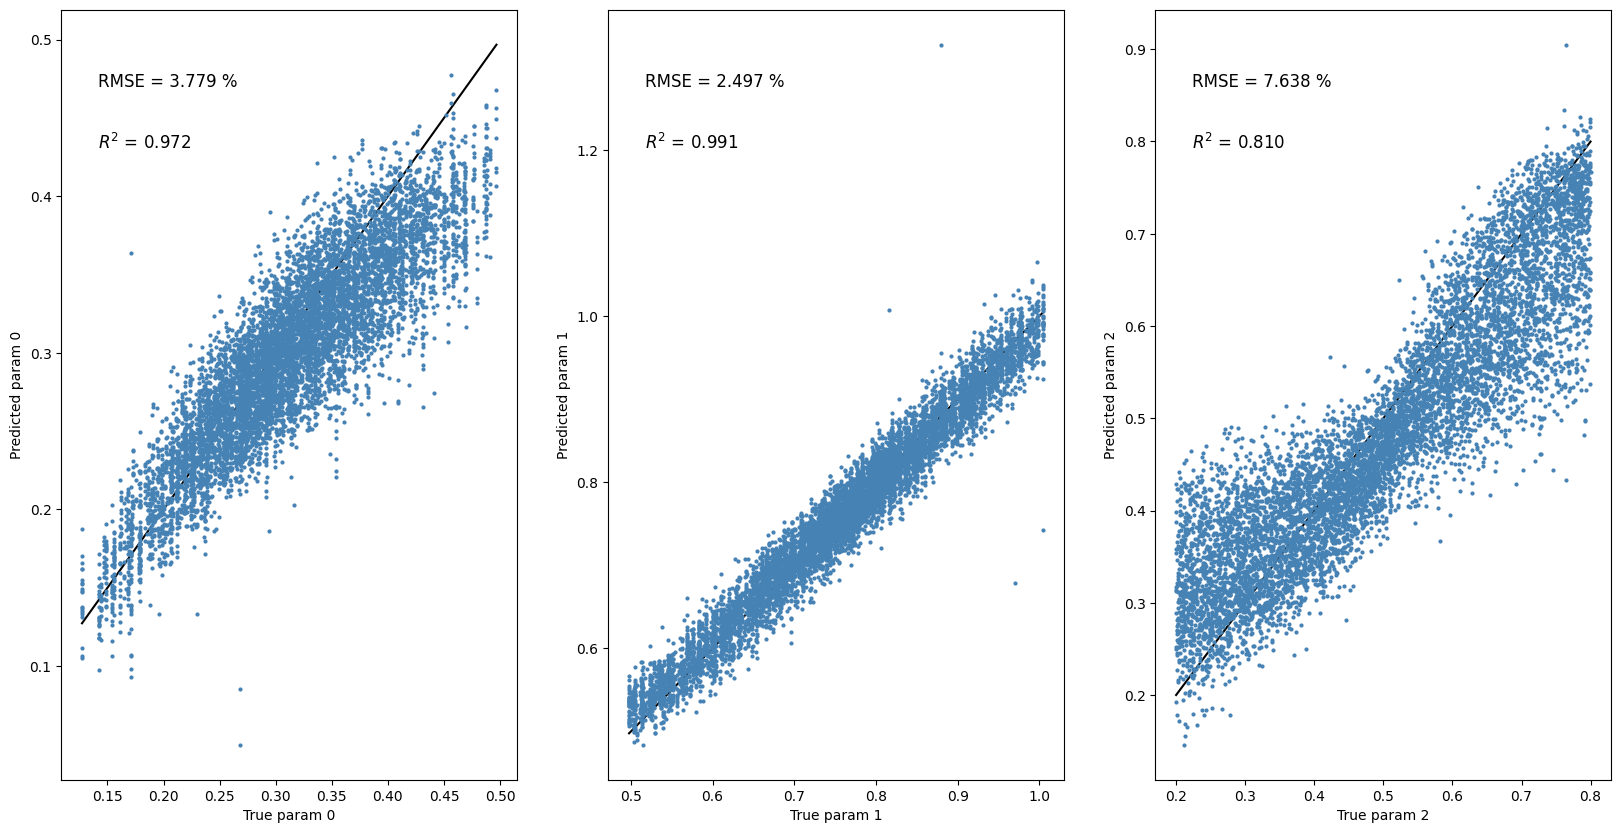

In [9]:
loaded_model = CompressionNN.load('piece_v4_pieceIdx_0')
loaded_model.model.to('cpu')

piece_idx = dv_separations[0]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.066
 $R^2$ = 0.915
Error S_8 = 18.835
test 0
test 1
test 2


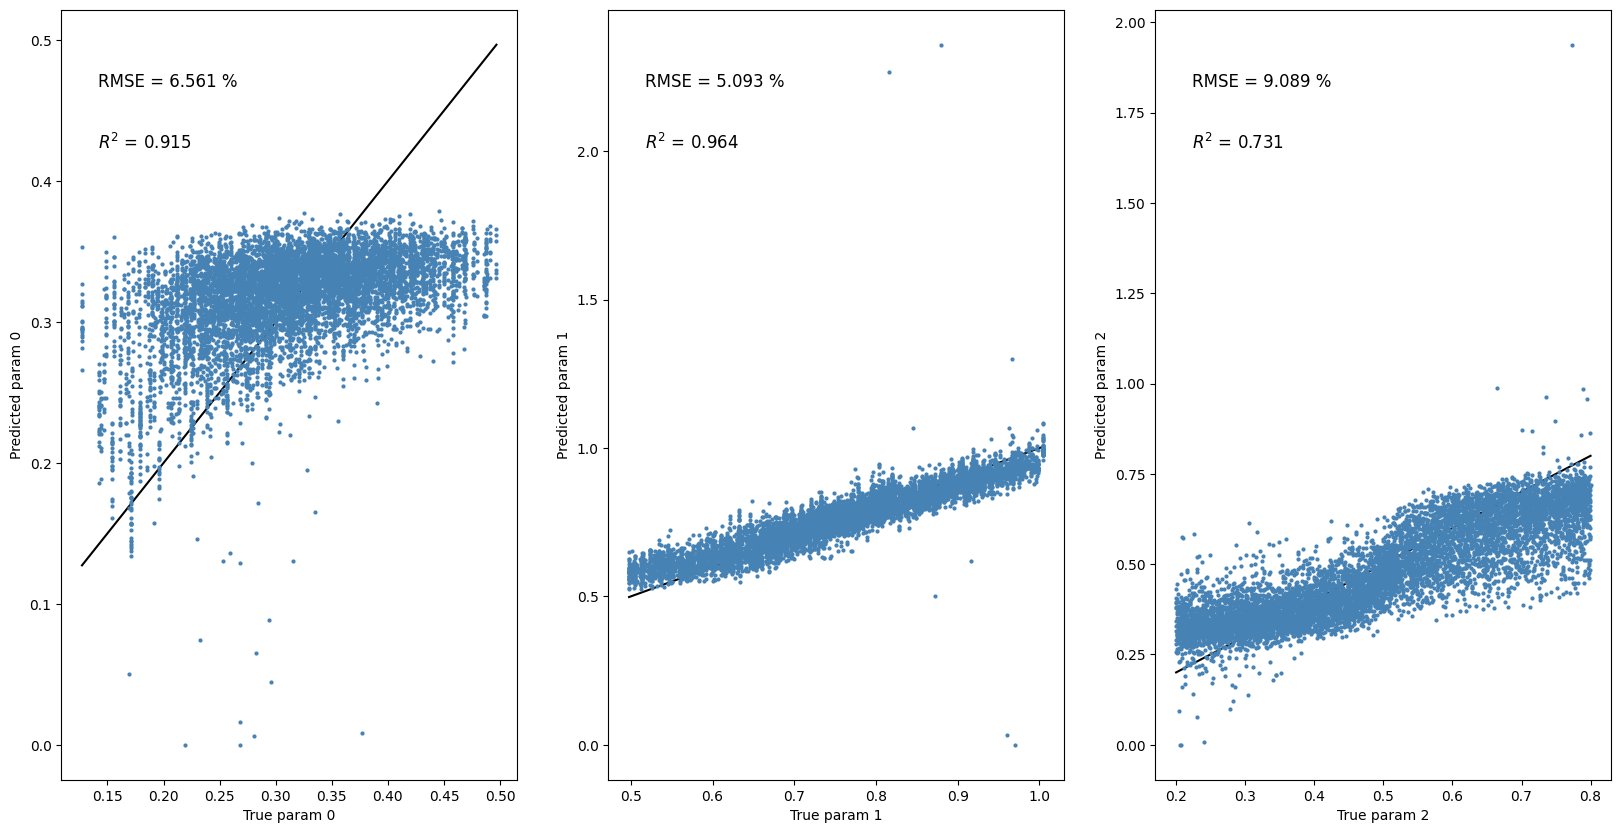

In [10]:
loaded_model = CompressionNN.load('piece_v4_pieceIdx_1')
loaded_model.model.to('cpu')

piece_idx = dv_separations[1]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


# Concatenate each latent space to a full compressed dv (excluding third moments cuz it's not constraining)

In [18]:
compressed_dv_semi_ae = np.zeros((dv_LFI.shape[0], 32))


for i, summary_idx in enumerate([0,1]):
    loaded_model = CompressionNN.load('piece_v4_pieceIdx_'+str(summary_idx))
    loaded_model.model.to('cpu')

    piece_idx = dv_separations[summary_idx]
    this_chunk_dv = dv_LFI[:,piece_idx]

    tmp = loaded_model.get_last_hidden_layer(this_chunk_dv)
    compressed_dv_semi_ae[:,16*i:16*(i+1)] = tmp

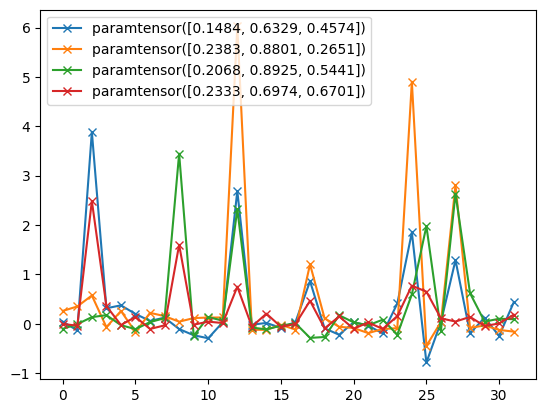

In [19]:
for i in [1,5,200,100]:
    plt.plot(compressed_dv_semi_ae[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
plt.legend()

# Test at fiducial cosmology

In [20]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]


In [21]:
dv_compressed_fid_ae = np.zeros((dv_set_fid.shape[0], 32))

for i, summary_idx in enumerate([0,1]):
    loaded_model = CompressionNN.load('piece_v4_pieceIdx_'+str(summary_idx))
    loaded_model.model.to('cpu')

    piece_idx = dv_separations[summary_idx]
    this_chunk_dv = dv_set_fid[:,piece_idx]

    tmp = loaded_model.get_last_hidden_layer(this_chunk_dv)
    dv_compressed_fid_ae[:,16*i:16*(i+1)] = tmp
    
dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae, axis=0)

In [22]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

((8187, 32), (32,))

In [23]:
np.save('./output/sim_compressed_dv_piecewise_v4', compressed_dv_semi_ae)
np.save('./output/fid_compressed_dv_piecewise_v4', dv_compressed_fid_ae)